### Resnet Model for TB - Version 2

In [8]:
!pip install matplotlib

     |████████████████████████████████| 11.2 MB 26.5 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.28.3-py3-none-any.whl (884 kB)
  Using cached kiwisolver-1.3.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [10]:
from __future__ import print_function
# import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
#from tensorflow.keras.datasets import cifar10

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

#Sources/credits
#https://tensorflow.keras.io/examples/cifar10_resnet/


In [11]:
# Training parameters
batch_size = 32
epochs = 30
#data_augmentation = True
num_classes = 2
input_dim = 512

# Subtracting pixel mean improves accuracy
#subtract_pixel_mean = True


In [12]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2


In [13]:
depth

20

In [14]:
import os
# import cv2
import pickle
import pandas as pd
import s3fs
fs = s3fs.S3FileSystem()

TRAIN_FILE_LOCATION = 's3://chexrayproject-v1.0-small/train/'

train_info_loc = fs.open(TRAIN_FILE_LOCATION)

TRAIN_CSV_FILE_LOCATION = 's3://chexrayproject-v1.0-small/train.csv'
# train_file_name = "train.csv"
train_info = pd.read_csv(fs.open(TRAIN_CSV_FILE_LOCATION))

len(train_info)

4074

In [15]:
train_info.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
4069,CheXpert-v1.0-small/train/patient00996/study3/...,Male,47,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,0.0
4070,CheXpert-v1.0-small/train/patient00997/study1/...,Female,63,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4071,CheXpert-v1.0-small/train/patient00997/study2/...,Female,64,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,NaN,NaN
4072,CheXpert-v1.0-small/train/patient00998/study1/...,Male,85,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN,1.0
4073,CheXpert-v1.0-small/train/patient00999/study1/...,Female,44,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0


In [25]:
train_info.fillna(0, inplace=True)
train_info.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

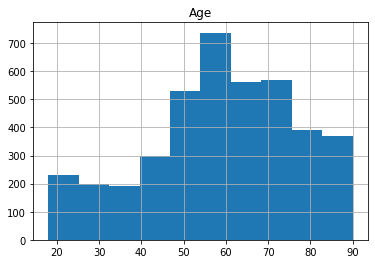

In [26]:
train_info.hist('Age')

In [27]:
col = list(train_info.columns)
diagnosis = col[5:]
diagnosis

['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

In [28]:
diagnosis_counts = train_info[['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']].apply(pd.value_counts)

In [29]:
diagnosis_counts.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
-1.0,NaN,237,160,99,28,226,469,316,562,45,193,53,23,13
0.0,3591.0,3660,3385,2190,3866,3014,3349,3655,2984,3679,2398,3927,3880,2116
1.0,483.0,177,529,1785,180,834,256,103,528,350,1483,94,171,1945


<AxesSubplot:>

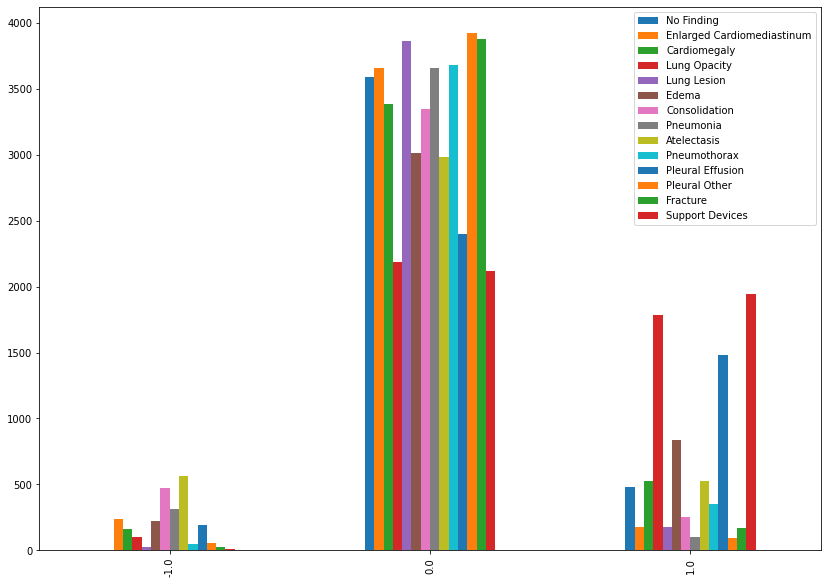

In [30]:
diagnosis_counts.plot(kind='bar', figsize=(14,10))

### Let us now stick to diagnosing one more common condition, say 'Pleural Effusion'

In [31]:
col

['Path',
 'Sex',
 'Age',
 'Frontal/Lateral',
 'AP/PA',
 'No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

In [32]:
train_pe = train_info[['Path','Pleural Effusion']]

In [33]:
train_pe.tail()

,Path,Pleural Effusion
4069,CheXpert-v1.0-small/train/patient00996/study3/...,-1.0
4070,CheXpert-v1.0-small/train/patient00997/study1/...,0.0
4071,CheXpert-v1.0-small/train/patient00997/study2/...,1.0
4072,CheXpert-v1.0-small/train/patient00998/study1/...,0.0
4073,CheXpert-v1.0-small/train/patient00999/study1/...,0.0


In [34]:
#Count the number of each condition
from collections import Counter

Counter(train_pe['Pleural Effusion']).most_common()

[(0.0, 2398), (1.0, 1483), (-1.0, 193)]

In [36]:
#Put all the names into a dataframe for convenience
images_df = pd.DataFrame(index=train_pe.index)
# images_df['xrays'] = [os.path.join('D:\\Documents\\git\\med_imaging',x) for x in train_pe['Path'].values]
images_df['xrays'] = [TRAIN_FILE_LOCATION + ('/').join(x.split('/')[-3:]) for x in train_pe['Path'].values]
images_df['masks'] = ''
images_df['pe'] = [str(x) for x in train_pe['Pleural Effusion'].values]

print("There are {} x-rays".format(len(images_df)))

There are 4074 x-rays


In [37]:
images_df.head()

,xrays,masks,pe
0,s3://chexrayproject-v1.0-small/train/patient00...,,0.0
1,s3://chexrayproject-v1.0-small/train/patient00...,,-1.0
2,s3://chexrayproject-v1.0-small/train/patient00...,,0.0
3,s3://chexrayproject-v1.0-small/train/patient00...,,0.0
4,s3://chexrayproject-v1.0-small/train/patient00...,,0.0


# Roshnaey, code in cell below (especially file paths for xrays column needs to be adjusted for AWS.

In [47]:
#'D:\\Documents\\git\\med_imaging\\CheXpert-v1.0-small'
#train_df = pd.DataFrame(index=train_info.index)
data_df = train_info[col[5:]].copy()
data_df['xrays'] = ['s3://chexrayproject-v1.0-small' + fs.sep + x for x in train_info['Path'].values] 

diag_cols = list(data_df.columns[:-1])
#print(diag_cols, len(diag_cols))

data_df.fillna(0, inplace=True)
#For now replace the -1: negative with 0: no finding
# data_df.replace(-1,0, inplace=True)

data_df.head(10)
data_df.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,xrays
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/CheXpert-v1.0-s...
1,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/CheXpert-v1.0-s...
2,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/CheXpert-v1.0-s...
3,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/CheXpert-v1.0-s...
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/CheXpert-v1.0-s...


In [ ]:
images_df.head()

,xrays,masks,pe
0,D:\Documents\git\med_imaging\CheXpert-v1.0-sma...,,0.0
1,D:\Documents\git\med_imaging\CheXpert-v1.0-sma...,,-1.0
2,D:\Documents\git\med_imaging\CheXpert-v1.0-sma...,,0.0
3,D:\Documents\git\med_imaging\CheXpert-v1.0-sma...,,0.0
4,D:\Documents\git\med_imaging\CheXpert-v1.0-sma...,,0.0


## Import the masking model

In [38]:
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [39]:
#https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset
#Use K instead of keras

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [40]:
#https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

def dice_coef(y_true, y_pred):
    y_true_f = tensorflow.keras.flatten(y_true)
    y_pred_f = tensorflow.keras.flatten(y_pred)
    intersection = tensorflow.keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tensorflow.keras.sum(y_true_f) + tensorflow.keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    #conv1 = Dropout(dropout)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    #conv2 = Dropout(dropout)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    #conv3 = Dropout(dropout)(conv3)
    conv3 = BatchNormalization()(conv3)    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    #conv4 = Dropout(dropout)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    #conv5 = Dropout(dropout)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    #up6 = Dropout(dropout)(up6)
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    #up7 = Dropout(dropout)(up7)
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    #up8 = Dropout(dropout)(up8)
    up7 = BatchNormalization()(up7)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    #up9 = Dropout(dropout)(up9)
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [41]:
#input_img = tf.tensorflow.keras.Input((1024, 1024, 1), name='img')
mask_model = unet(input_size=(input_dim,input_dim,1))

#model = get_unet(input_img)
mask_model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])
mask_model.summary()

[2021-12-13 17:14:38.706 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:68 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-13 17:14:38.731 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:68 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (

### Now load the masking model

In [ ]:
from tensorflow.keras.models import load_model

#custom_objects={'focal_loss': focal_loss,'fbeta_score':fbeta_score}
# load model
#model.save('mask_segmentation_unet_augmented_4_5_20_model.h5')
mask_model = load_model('mask_segmentation_unet_augmented_4_3_20_model.h5', \
                   custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
#model = load_model('cxr_reg_weights.best.hdf5')

In [ ]:
#mask_model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])

### https://www.tensorflow.org/tutorials/load_data/images

In [42]:
batch_size = 32
img_height = 512
img_width = 512

In [43]:
label_list1 = data_df['No Finding']
#label_list = data_df[diagnosis]
print(len(label_list1))

NameError: name 'data_df' is not defined

In [ ]:
list(label_list1.values)

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [ ]:
count = 0
f_name = []
for root, dirs, files in os.walk('D:\\Documents\\git\\med_imaging\\CheXpert-v1.0-small\\train\\'):
     for file in files:
        count += 1
        f_name.append(file)
        
print(count)

223414


In [ ]:
f_name

['view1_frontal.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view2_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view2_lateral.jpg',
 'view1_frontal.jpg',
 'view1_fr

In [ ]:
data_dir = 'D:\\Documents\\git\\med_imaging\\CheXpert-v1.0-small\\train\\'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, labels = list(label_list1.values), label_mode= None, validation_split=0.2,
  subset="training",
  seed=123,                                                    
  color_mode = "grayscale",                                                             
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 223414 files belonging to 64540 classes.
Using 178732 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, labels = list(label_list1.values), label_mode=None,
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode = "grayscale",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 223414 files belonging to 64540 classes.
Using 44682 files for validation.


In [ ]:
for image_batch in train_ds:
    print(image_batch.shape)
    print(np.min(image_batch), np.max(image_batch))
    break

(32, 512, 512, 1)
0.0 255.0


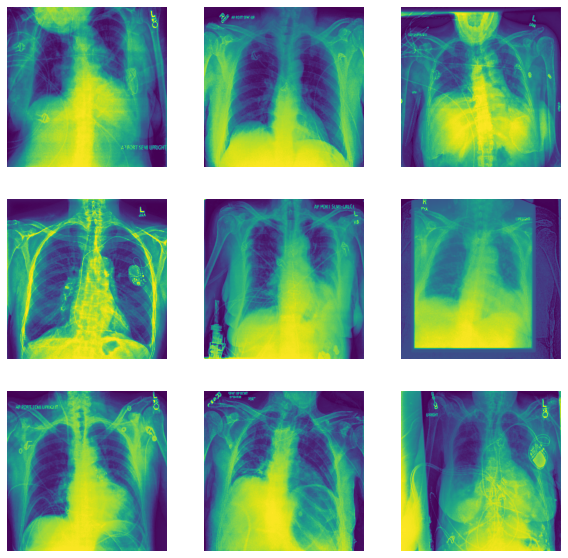

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    #print(images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]/255)
        #plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
res = []
for images in train_ds.take(1):
    print(images[0].shape)
    preds = mask_model.predict(images/255)
    for i in range(preds.shape[0]):
    #print(g_img[0][i].shape)
    #print(preds[0].shape)
        cutout = np.zeros(preds[i].shape)
        ids = preds[i] < .53
        cutout[ids] = (images[i]/255)[ids]
        res.append(cutout)
print(len(res))

(512, 512, 1)
32


In [ ]:
print(np.min(preds), np.max(preds))
res[7].shape

In [ ]:
plt.figure(figsize=(12, 24))
for i in range(len(res)):
    ax = plt.subplot(int(len(res)/4), 4, i + 1)
    plt.imshow(res[i])
    #plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
len(train_ds)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE 

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
##See whether we can diagnose 
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#report_list = [str(report) for report in report_df.report.values]
#diagnosis = le.fit_transform(y_data)

In [ ]:
from tensorflow.keras.utils import to_categorical
one_hot_y = to_categorical(label_list1.values)

In [ ]:
one_hot_y.shape

(50, 3)

In [ ]:
import pickle

#with open('masked_1xaugmented_cheXpert_y_4_20_20.pkl', 'wb') as f:
#    pickle.dump(masked_1xaugmented_X_rays_y, f,protocol=4)

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
num_classes = one_hot_y.shape[1]
#num_classes = 2
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=num_classes):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [ ]:
def resnet_v2(input_shape, depth, num_classes=num_classes):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
version

1

In [ ]:
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
#from keras import backend as K
input_shape = (512, 512, 1)
#X.shape[1:]
#Choose version here
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

#model = resnet_v2(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)


Learning rate:  0.001
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
_________________________________________________________________

In [ ]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'CheXpert_{}_model_epochs{}.h5'.format(model_type, epochs)
#model_name = 'TB_ver1_%s_model.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [ ]:
model_name

'CheXpert_ResNet20v1_model_epochs1.h5'

In [ ]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [ ]:

from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(X, one_hot_y, test_size=0.1, random_state=1)


x_t, x_v, y_t, y_v = train_test_split(x_tr, y_tr, test_size=0.1, random_state=1)

(x_train, y_train) = x_t, y_t
(x_val, y_val) = x_v, y_v
(x_test, y_test) = x_te, y_te

In [ ]:
#model.fit_generator(masked_gen,steps_per_epoch=800,epochs=3,use_multiprocessing=True, workers=-1, 
#                              validation_data=masked_gen, validation_steps=5,
#                              callbacks=callbacks, verbose=0)


# Run training, with or without data augmentation.
#model.fit(x_train, y_train, batch_size=8, epochs=30,
#          validation_data=(x_val, y_val), shuffle=True)
epochs = 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
# Run training, with or without data augmentation.
#model.fit(x_train, y_train, batch_size=16, epochs=70,
#          validation_data=(x_test, y_test), shuffle=True, callbacks=callbacks)

AttributeError: in user code:

    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\keras\engine\training.py:759 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:388 update_state
        self.build(y_pred, y_true)
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:318 build
        self._metrics = nest.map_structure_up_to(y_pred, self._get_metric_objects,
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\util\nest.py:1135 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\util\nest.py:1234 map_structure_with_tuple_paths_up_to
        results = [func(*args, **kwargs) for args in zip(flat_path_list,
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\util\nest.py:1234 <listcomp>
        results = [func(*args, **kwargs) for args in zip(flat_path_list,
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\util\nest.py:1137 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:419 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:419 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\gavir\.conda\envs\geo\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:440 _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'NoneType' object has no attribute 'shape'


In [ ]:
#Save this way also

from tensorflow.keras.models import load_model, save_model

filepath = os.path.join(save_dir, model_name)
# load model
#model.save(filepath = filepath)
#model = load_model('model.h5')

In [ ]:
from tensorflow.keras.models import load_model, save_model
#loaded_model = load_model(os.path.join(save_dir, 'CheXpert_ResNet20v1_model_epochs30.h5'))
loaded_model = load_model('./saved_models/CheXpert_ResNet20v1_model_epochs30.h5')

In [ ]:
#for i in range(150):
#    test_data.append(next(masked_gen))

In [ ]:
preds = loaded_model.predict(x_test)

In [ ]:
preds

array([[6.6719252e-08, 1.8926697e-04, 9.9981064e-01],
       [1.1212884e-09, 9.9993527e-01, 6.4692678e-05],
       [1.2778198e-08, 7.3719034e-06, 9.9999261e-01],
       [7.6829778e-08, 9.9999833e-01, 1.5461503e-06],
       [2.8916820e-18, 9.9999976e-01, 2.1705291e-07]], dtype=float32)

In [ ]:
y_hat = np.argmax(preds, axis = 1)

In [ ]:
y_diag_codes = np.argmax(y_test, axis = 1)

In [ ]:
y_hat == y_diag_codes

array([ True,  True, False,  True,  True])

In [ ]:
#y_train_diagnosis = le.inverse_transform()
#y

In [ ]:
y_pred_diagnosis = le.inverse_transform(y_hat)

In [ ]:
y_diagnosis = le.inverse_transform(y_diag_codes)

In [ ]:
#y_diagnosis == y_pred_diagnosis

In [ ]:
missed = [(a,b) for a,b in zip(y_diagnosis,y_pred_diagnosis) if b != a]
missed

[('-1.0', '1.0')]

In [ ]:
Counter(y_diag_codes).most_common()

[(1, 3), (2, 1), (0, 1)]

In [ ]:
Counter(y_hat).most_common()

[(1, 3), (2, 2)]

In [ ]:
Counter(y_data).most_common()

[('0.0', 25), ('1.0', 18), ('-1.0', 7)]

In [ ]:
set(missed)

{('-1.0', '1.0')}

In [ ]:
correct = [a for a,b in zip(y_diagnosis,y_pred_diagnosis) if b == a]
correct

['1.0', '0.0', '0.0', '0.0']

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1/1 [==============================] - 0s 998us/step - loss: 23.9913 - accuracy: 0.4000
Test loss: 23.99132537841797
Test accuracy: 0.4000000059604645


In [ ]:
# Score trained model.
scores = loaded_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1/1 [==============================] - 0s 998us/step - loss: 3.6461 - accuracy: 0.8000
Test loss: 3.6461329460144043
Test accuracy: 0.800000011920929
